In [9]:
import os
import sys
import tempfile
import numpy as np
import h5py
import torch

import matplotlib.pyplot as plt

from datetime import datetime
import pandas as pd
from numpy.random import default_rng
    

In [8]:
!pip install matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 133.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


In [10]:

def read_record(record):
    """Reads a single line from the dataset."""
    radar_back_file = record["radar_file_path_back"]
    radar_back_future = record["radar_file_path_future"]

    gs_future = record["groundstation_file_path_future"]
    gs_back = record["groundstation_file_path_back"]

    height = record["ground_height_file_path"]

    hour = record["hour"]
    minutes = record["minute"]
    time_radar_back = record["time_radar_back"]
    datetime = record["datetime"]
    id = record["id"]

    # Load the all the npz files
    npz_paths = [radar_back_file, radar_back_future, gs_future, gs_back, height]
    # Check if all files exist
    for npz_path in npz_paths:
        if not os.path.exists(npz_path):
            print(f"File not found: {npz_path}")
            continue
    # Load the npz files
    try:
        radar_back_data = np.load(radar_back_file)[
            "arr_0"
        ]  # Assuming the data is stored under 'arr_0'
        radar_future_data = np.load(radar_back_future)["arr_0"]
        gs_future_data = np.load(gs_future)["arr_0"]
        gs_back_data = np.load(gs_back)["arr_0"]
        height_data = np.load(height)["arr_0"]
    except Exception as e:
        print(
            f"Error loading data from {radar_back_file}, {radar_back_future}, {gs_future}, {gs_back}, {height}: {e}"
        )
        raise ("Error")

    gs_back_data = np.where(gs_back_data == -100, -1, gs_back_data)
    gs_back_data = np.where(np.isnan(gs_back_data), -1, gs_back_data)

    gs_future_data = np.where(gs_future_data == -100, -1, gs_future_data)
    gs_future_data = np.where(np.isnan(gs_future_data), -1, gs_future_data)

    return {
        "radar_back": radar_back_data,  # The NumPy array itself
        "radar_future": radar_future_data,  # The NumPy array itself
        "groundstation_future": gs_future_data,  # The NumPy array itself
        "groundstation_back": gs_back_data,  # The NumPy array itself
        "ground_height": height_data,  # The NumPy array itself
        # "hour": hour,  # The scalar value
        # "minutes": minutes,  # The scalar value
        # "time_radar_back": time_radar_back,  # The scalar value
        # "datetime": datetime,  # The scalar value
        # "id": id,  # The scalar value
    }


class MeteoLibreDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, directory):
        super().__init__()

        self.directory = directory

        # index reader
        self.json_path = os.path.join(self.directory, "index_test.json")
        self.index_data = pd.read_json(self.json_path, orient="columns", lines=True)

        for columns in self.index_data.columns:
            if "file" in columns:
                self.index_data[columns] = directory + self.index_data[columns].str[19:]

    def __len__(self):
        return len(self.index_data)

    def __getitem__(self, item):
        row = self.index_data.iloc[item]

        # read data
        data = read_record(row)

        return data

In [11]:
dataset = MeteoLibreDataset(directory="/home/adrienbufort/meteolibre_dataset/data/hf_dataset/")


In [20]:
data = dataset[1233]
print(data.keys())

dict_keys(['radar_back', 'radar_future', 'groundstation_future', 'groundstation_back', 'ground_height'])


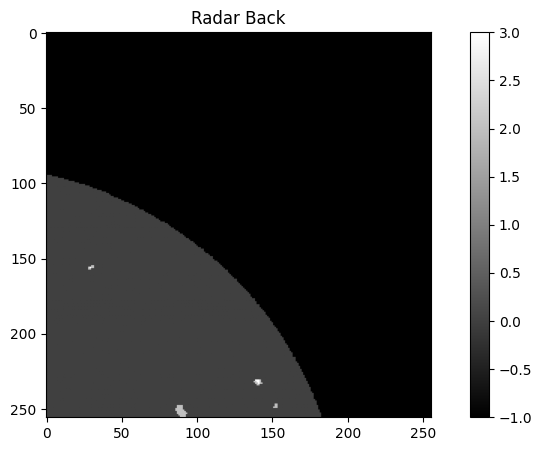

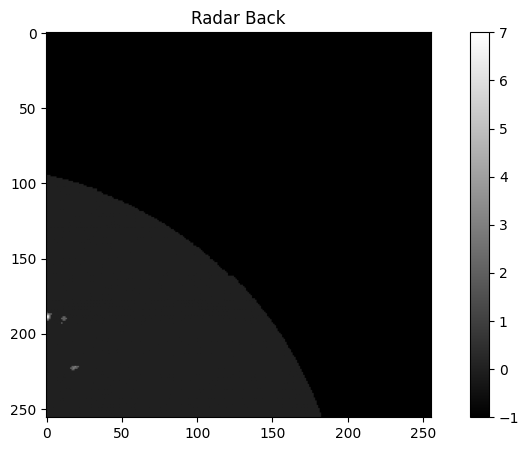

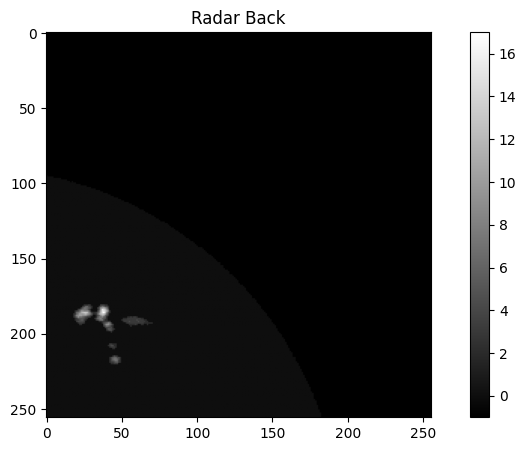

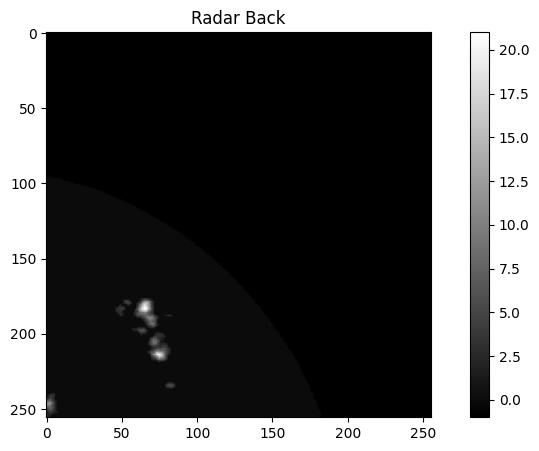

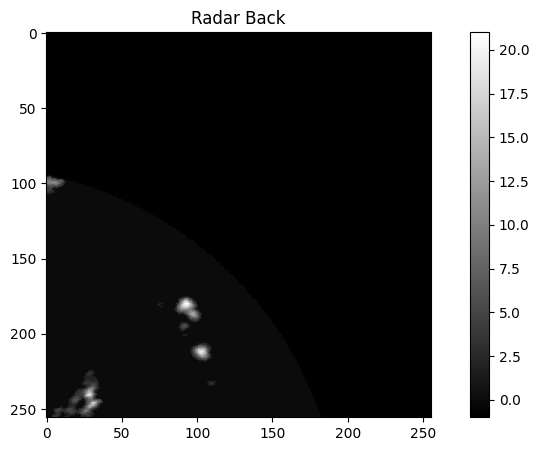

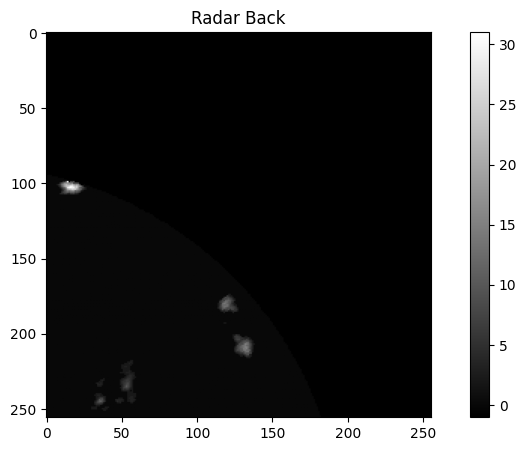

In [21]:
radar_back = data['radar_back'] * 60


# we plot the radar_back and the radar_future
for i in range(radar_back.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.imshow(radar_back[i], cmap='gray')
    plt.title('Radar Back')
    plt.colorbar()